# Trabalho prático - Visão por Computador e Processamento de Imagem

#### Autores: Cláudio Moreira (PG47844), Filipe Fernandes(A83996)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

# to determine the most voted
import collections 

In [2]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()

def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    


def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()    



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    

In [3]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]

In [17]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

DATA_PREFIX = 'GTSRB_TP/'

TRAIN_ONLINE = False # if False it will train models, otherwise it will load weights
trained_models = ['TrainModels/static_Augmentation.ckpt',
'TrainModels/noAugmentation.ckpt','TrainModels/noAugmentation_Balance.ckpt', 'TrainModels/Dynamic_Augmentation.ckpt', 'TrainModels/Massive_Augmentation.ckpt']

In [5]:
data_dir = pathlib.Path(DATA_PREFIX + 'train_images/')
  
classNames = np.array(os.listdir(data_dir))
NUM_CLASSES = len(classNames)
classNames


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007', '00008', '00009', '00010', '00011', '00012', '00013',
       '00014', '00015', '00016', '00017', '00018', '00019', '00020',
       '00021', '00022', '00023', '00024', '00025', '00026', '00027',
       '00028', '00029', '00030', '00031', '00032', '00033', '00034',
       '00035', '00036', '00037', '00038', '00039', '00040', '00041',
       '00042'], dtype='<U5')

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(DATA_PREFIX + 'train_images/*/*.png')
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



In [7]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", dataset_length)  

(32, 32, 3) (43,)
Total images in dataset:  39220


In [8]:

dataSolo = dataset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.shuffle(buffer_size = dataset_length)
dataSolo = dataSolo.prefetch(buffer_size=dataset_length)
dataSolo = dataSolo.batch(batch_size=BATCH_SIZE)

In [9]:
train_size = int(0.8*dataset_length)
val_size = int(0.2*dataset_length)

In [10]:
dataSolo = dataSolo.take(train_size)
valset = dataSolo.skip(train_size)

In [11]:
test_listset = tf.data.Dataset.list_files(DATA_PREFIX + 'test_images/*/*.png')
test_dataset_length = test_listset.cardinality().numpy()
print("Total images in validatation dataset: ", test_dataset_length)

testset = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size = BATCH_SIZE)

Total images in validatation dataset:  12630


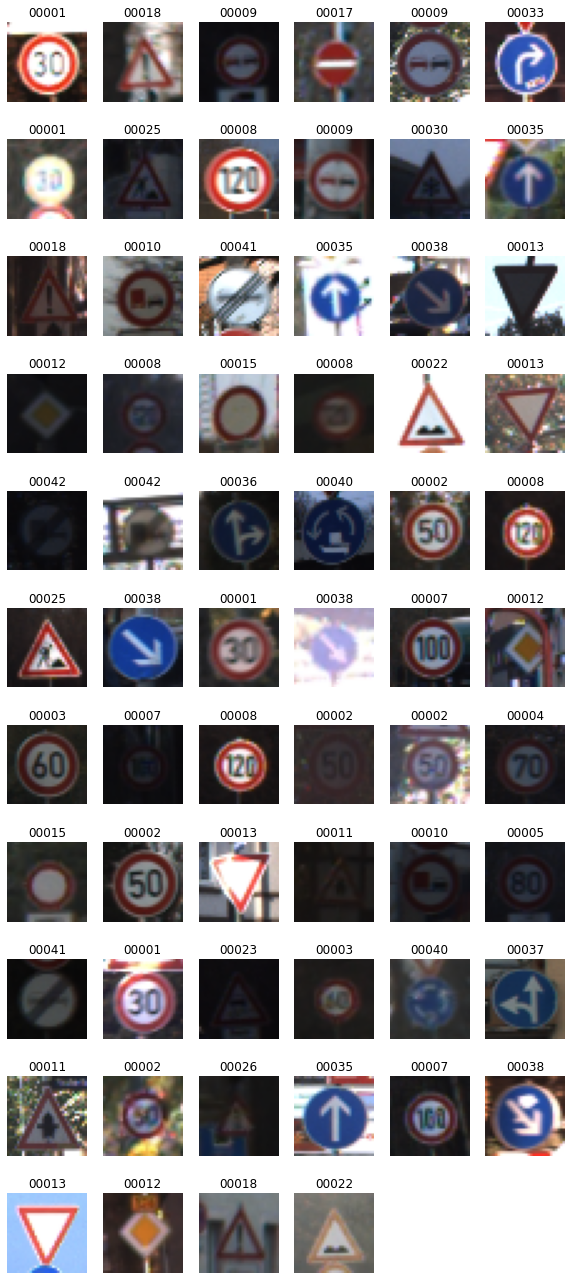

In [12]:
image_batch, label_batch = next(iter(dataSolo))        
show_batch(image_batch, label_batch.numpy())

In [13]:
def create_model(classCount, imgSize, channels):
    modelLogits = Sequential()

    modelLogits.add(Conv2D(128, (5, 5),
                        input_shape=(32, 32, 3)))         
    modelLogits.add(LeakyReLU(alpha=0.01))  
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(196, (5, 5) )) 
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Conv2D(256, (5, 5) ) )   
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    modelLogits.add(BatchNormalization())
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Flatten())
    modelLogits.add(LeakyReLU(alpha=0.0)) 
    modelLogits.add(Dense(384))
    modelLogits.add(LeakyReLU(alpha=0.0))             
    modelLogits.add(Dropout(0.5)) 

    modelLogits.add(Dense(classCount))

    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output) 

    opt = Adam(learning_rate=0.0001)

    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits

In [14]:
NUM_MODELS = len(trained_models)


In [25]:

def train_model_func(train, val):
    models = []
    histories = []
    hist=[]
    for i in range(NUM_MODELS):
        
        model, modelL = create_model(NUM_CLASSES,IMAGE_SIZE,3)

        if TRAIN_ONLINE:
            
            callbacks = prepare_callbacks(trained_models[i])
            hist = model.fit(train, 
                            epochs=100, 
                            validation_data = val, 
                            callbacks = callbacks)
        
        models.append([model, modelL])
        histories.append(hist)
    
    return models,histories

models_V1, histories_V1 = train_model_func(dataSolo, valset)

In [26]:
def load_weights(models):

    for i in range(NUM_MODELS):

        file_path = trained_models[i]

        models[i][0].load_weights(file_path)
        models[i][0].save('temp.hdf5')
        models[i][1].load_weights('temp.hdf5', by_name=True)
        

load_weights(models_V1)

IndexError: list index out of range

In [27]:
def evaluate_models(models):
    
    accuracy = 0

    for i in range(NUM_MODELS):

        eval = models[i][0].evaluate(testset, verbose = 2)
        accuracy += eval[1]

    print(f'average accuracy: {(accuracy/NUM_MODELS)*100:.3f}')    


evaluate_models(models_V1)

198/198 - 58s - loss: 52.0927 - accuracy: 0.0000e+00 - 58s/epoch - 293ms/step
198/198 - 59s - loss: 29.4303 - accuracy: 6.3341e-04 - 59s/epoch - 300ms/step
198/198 - 61s - loss: 63.3005 - accuracy: 2.3753e-04 - 61s/epoch - 307ms/step
198/198 - 59s - loss: 48.0929 - accuracy: 1.5835e-04 - 59s/epoch - 300ms/step
198/198 - 57s - loss: 83.5851 - accuracy: 7.9177e-05 - 57s/epoch - 290ms/step
198/198 - 62s - loss: 3.7543 - accuracy: 0.0356 - 62s/epoch - 313ms/step
average accuracy: 0.612


In [30]:
def get_labels_logits_and_preds(models):

    preds = [[] for _ in range(NUM_MODELS) ]
    logits = [[] for _ in range(NUM_MODELS)]
    labels = []
    for images, labs in testset.take(-1):

        labels.extend(labs.numpy())
        for i in range(NUM_MODELS):

            preds[i].extend(models[i][0].predict(images))
            logits[i].extend(models[i][1].predict(images))

    labels = [np.argmax(i) for i in labels]  
    
    return labels, logits, preds

labels_V1, logits_V1, preds_V1 = get_labels_logits_and_preds(models_V1)

1/1 [==============================] - 0s 188ms/step


In [29]:
def get_class_preds(preds):

    class_preds = []

    for i in range(test_dataset_length):

        c = []
        for m in range(NUM_MODELS):

            c.append(np.argmax(preds[m][i]))
        class_preds.append(c)
        
    return class_preds


class_preds_V1 = get_class_preds(preds_V1)

NameError: name 'preds_V1' is not defined

In [ ]:
def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(test_dataset_length):

        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    
class_logits_V1 = get_class_from_sum_of_logits(logits_V1)

In [ ]:
def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0
    log_ok = 0
    log_ko = 0

    for k in range(test_dataset_length):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1
        if class_logits[k] == labels[k]:
            log_ok += 1
        else:
            log_ko += 1
        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko]
    
    
res = get_stats(labels_V1, class_preds_V1, class_logits_V1)
print(res, res[6]/res[0])